# Enrichment Analysis Notebook

Compares the results of SPINDOCTOR gene set summarization vs statistical ontological enrichment

## Initial setup

Here we take care of imports, defining the data dictionary for the pandas dataframes

In [1]:
import yaml
from yaml import Loader
import pandas as pd
from oaklib import get_adapter
from oaklib.datamodels.vocabulary import IS_A, PART_OF
go = get_adapter("sqlite:obo:go")

In [2]:
# data dictionary
MODEL = "model"
METHOD = "method"
HAS_TOP_HIT = "has top hit"
IN_TOP_5 = "in top 5"
IN_TOP_10 = "in top 10"
RANK = "rank"
SIZE_OVERLAP = "size overlap"
SIMILARITY = "similarity"
NR_SIZE_OVERLAP = "nr size overlap"
NR_SIMILARITY = "nr similarity"
GENESET = "geneset"
SOURCE_GENESET = "source geneset"
GENESET_SIZE = "geneset_size"
TRUNCATION_FACTOR = "truncation factor"
NUM_TERMS = "num terms"
NUM_UNPARSED = "num unparsed"
TERM_IDS = "term ids"


TURBO = "gpt-3.5-turbo"
DAVINCI = "text-davinci-003"
MODELS = [TURBO, DAVINCI]

In [3]:
from ontogpt.evaluation.enrichment.eval_enrichment import GeneSetComparison, Overlap

In [4]:
# assumes comparisons have been run (see Makefile) and concatenated
def load_comparisons():
    with open(f"../analysis/enrichment-summary.yaml") as f:
        obj = yaml.load(f, Loader)
        comps = [GeneSetComparison(**x) for x in obj]
        return comps

In [5]:
comps = load_comparisons()

In [6]:
comps[0].name

'EDS-0'

In [7]:
list(comps[0].__dict__.keys())

['name',
 'gene_symbols',
 'model',
 'payloads',
 'overlaps',
 'number_of_genes_swapped_out']

In [8]:
payload = comps[0].payloads["gpt-3.5-turbo.no_synopsis"]
list(payload.__dict__.keys())

['prompt',
 'response_text',
 'truncation_factor',
 'summary',
 'term_strings',
 'term_ids',
 'ontological_synopsis',
 'combined_synopsis',
 'annotations',
 'response_token_length',
 'model',
 'method']

In [9]:

def filter_redundant(term_ids):
    cumulative_ancs = set()
    visited = set()
    for t in term_ids:
        visited.add(t)
        if t in cumulative_ancs:
            # a descendant of t has been encountered
            continue
        ancs = list(go.ancestors(t, [IS_A, PART_OF]))
        cumulative_ancs.update(ancs)
        if (visited-{t}).intersection(ancs):
            # t is a descendant of a term that has been encountered
            continue
        yield t

# test
list(filter_redundant(["GO:0005773", "GO:0005634", "GO:0031965", "GO:0008150"]))

['GO:0005773', 'GO:0005634', 'GO:0008150']

In [10]:
import re
def eval_payload(comp, method, payload, expected):
    expected_nr_ids = list(filter_redundant(expected.term_ids))
    name = comp.name
    model = payload.model
    # temp...
    if not model:
        toks = method.split(".")
        for m in MODELS:
            if method.startswith(m):
                model = m
                method = method.replace(f"{m}.", "")
                break
    if not model:
        model = "N/A"
    tf = payload.truncation_factor
    if not tf:
        tf = 1.0
    nr_term_ids = list(filter_redundant(payload.term_ids))
    unparsed_term_ids = [t for t in payload.term_ids if not re.match(r'^\S+:w+$', t)]
    obj = {MODEL: model, METHOD: method, GENESET: name, TRUNCATION_FACTOR: tf}
    name_toks = name.split("-")
    obj[SOURCE_GENESET] = "-".join(name_toks[0:-1])
    if not expected.term_ids:
        #print(f"Nothing expected for {name}")
        # top_term_id = "FAKE:123"
        return
    else:
        top_term_id = expected.term_ids[0]
    obj[HAS_TOP_HIT] = top_term_id in payload.term_ids
    in_top_5 = False
    in_top_10 = False
    if top_term_id in payload.term_ids:
        rank = payload.term_ids.index(top_term_id)
        obj[RANK] = rank
        in_top_5 = rank < 5
        in_top_10 = rank < 10
    obj[IN_TOP_5] = in_top_5
    obj[IN_TOP_10] = in_top_10
    overlap = set(payload.term_ids).intersection(expected.term_ids)
    obj[SIZE_OVERLAP] = len(overlap)
    nr_overlap = set(nr_term_ids).intersection(expected_nr_ids)
    obj[NR_SIZE_OVERLAP] = len(nr_overlap)
    size_union = len(set(payload.term_ids).union(expected.term_ids))
    if size_union:
        obj[SIMILARITY] = len(overlap) / len(set(payload.term_ids).union(expected.term_ids))
    nr_size_union = len(set(nr_term_ids).union(expected_nr_ids))
    if nr_size_union:
        obj[NR_SIMILARITY] = len(nr_overlap) / len(set(nr_term_ids).union(expected_nr_ids))
    obj['number_of_terms'] = len(payload.term_ids)
    obj[GENESET_SIZE] = len(comp.gene_symbols)
    obj[TERM_IDS] = payload.term_ids
    obj['term_strings'] = payload.term_strings
    obj[NUM_TERMS] = len(payload.term_ids)
    obj[NUM_UNPARSED] = len(unparsed_term_ids)
    return obj

objs = []
for comp in comps:
    expected = comp.payloads["standard"]
    for method, payload in comp.payloads.items():
        obj = eval_payload(comp, method, payload, expected)
        if obj:
            objs.append(obj)
df = pd.DataFrame(objs)
df.to_csv("enr.csv")
df

,model,method,geneset,truncation factor,source geneset,has top hit,rank,in top 5,in top 10,size overlap,nr size overlap,similarity,nr similarity,number_of_terms,geneset_size,term ids,term_strings,num terms,num unparsed
0,gpt-3.5-turbo,no_synopsis,EDS-0,1.0,EDS,True,0.0,True,True,5,4,0.116279,0.285714,5,19,"[GO:0030199, GO:0030198, GO:0032963, GO:003016...","[collagen fibril organization, extracellular m...",5,5
1,gpt-3.5-turbo,ontological_synopsis,EDS-0,1.0,EDS,True,1.0,True,True,3,0,0.068182,0.000000,4,19,"[GO:0030198, GO:0030199, GO:0032964, GO:0062023]","[extracellular matrix organization, collagen f...",4,4
2,gpt-3.5-turbo,narrative_synopsis,EDS-0,1.0,EDS,False,NaN,False,False,1,1,0.021739,0.058824,4,19,"[GO:0032964, GO:0030166, GO:0043687, MESH:D005...","[collagen biosynthetic process, proteoglycan b...",4,4
3,text-davinci-003,no_synopsis,EDS-0,1.0,EDS,False,NaN,False,False,0,0,0.000000,0.000000,4,19,"[MESH:D005796, MESH:D003094, MESH:D002356, and...",[the genes provided are mainly involved in ext...,4,4
4,text-davinci-003,ontological_synopsis,EDS-0,1.0,EDS,True,1.0,True,True,2,0,0.041667,0.000000,7,19,"[GO:0030198, GO:0030199, MESH:D012867, GO:0035...","[extracellular matrix organization, collagen f...",7,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,text-davinci-003,narrative_synopsis,sensory ataxia-1,1.0,sensory ataxia,False,NaN,False,False,0,0,0.000000,0.000000,11,15,"[MESH:D009186, MESH:D025801, MESH:D011506, GO:...","[peripheral nerve myelin upkeep, e3 ubiquitin ...",11,11
836,N/A,standard,sensory ataxia-1,1.0,sensory ataxia,True,0.0,True,True,9,3,1.000000,1.000000,9,15,"[GO:0042552, GO:0008366, GO:0007272, GO:000742...","[myelination, axon ensheathment, ensheathment ...",9,9
837,N/A,standard_no_ontology,sensory ataxia-1,1.0,sensory ataxia,False,NaN,False,False,0,0,0.000000,0.000000,0,15,[],[],0,0
838,N/A,random,sensory ataxia-1,1.0,sensory ataxia,False,NaN,False,False,0,0,0.000000,0.000000,14,15,"[GO:1990928, GO:0005737, GO:0035335, GO:000965...","[response to amino acid starvation, cytoplasm,...",14,14


In [11]:
df[[SOURCE_GENESET]].drop_duplicates()

,source geneset
0,EDS
40,FA
80,HALLMARK_APICAL_JUNCTION
120,HALLMARK_GLYCOLYSIS
160,HALLMARK_HEDGEHOG_SIGNALING
200,HALLMARK_INTERFERON_GAMMA_RESPONSE
240,HALLMARK_MTORC1_SIGNALING
280,Yamanaka-TFs
320,amigo-example
360,bicluster_RNAseqDB_0


In [14]:
df[[SOURCE_GENESET, GENESET_SIZE]].drop_duplicates().style.hide_index()

/var/folders/nc/m4tx21912kv1b8nk3zzx9plr0000gn/T/ipykernel_74222/3852654709.py:1: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  df[[SOURCE_GENESET, GENESET_SIZE]].drop_duplicates().style.hide_index()


source geneset,geneset_size
EDS,19
FA,19
HALLMARK_APICAL_JUNCTION,200
HALLMARK_GLYCOLYSIS,200
HALLMARK_HEDGEHOG_SIGNALING,36
HALLMARK_INTERFERON_GAMMA_RESPONSE,200
HALLMARK_MTORC1_SIGNALING,200
Yamanaka-TFs,4
amigo-example,36
bicluster_RNAseqDB_0,158


In [53]:
eval_summary_cols = [MODEL, METHOD, HAS_TOP_HIT, IN_TOP_5, IN_TOP_10, SIZE_OVERLAP, SIMILARITY, NUM_TERMS, NR_SIZE_OVERLAP, NR_SIMILARITY]
means = df[eval_summary_cols].groupby([MODEL, METHOD]).mean(numeric_only=True)
means

has top hit  in top 5  in top 10  \
model            method                                                   
N/A              random                       0.04      0.01       0.01   
                 rank_based                   0.05      0.00       0.00   
                 standard                     1.00      1.00       1.00   
                 standard_no_ontology         0.19      0.12       0.14   
gpt-3.5-turbo    narrative_synopsis           0.15      0.14       0.15   
                 no_synopsis                  0.20      0.20       0.20   
                 ontological_synopsis         0.23      0.23       0.23   
text-davinci-003 narrative_synopsis           0.13      0.08       0.13   
                 no_synopsis                  0.10      0.07       0.10   
                 ontological_synopsis         0.18      0.12       0.17   

                                       size overlap  similarity  num terms  \
model            method                                                      
N/A              random                        4.26        0.01      66.56   
                 rank_based                    8.04        0.02      75.71   
                 standard                    162.69        1.00     162.69   
                 standard_no_ontology         12.68        0.08      16.18   
gpt-3.5-turbo    narrative_synopsis            2.10        0.02       5.38   
                 no_synopsis                   2.54        0.02       5.85   
                 ontological_synopsis          2.29        0.03       5.67   
text-davinci-003 narrative_synopsis            1.56        0.01      10.04   
                 no_synopsis                   1.61        0.01       8.44   
                 ontological_synopsis          2.12        0.02      11.67   

                                       nr size overlap  nr similarity  
model            method                                                
N/A              random                           0.38       5.47e-03  
                 rank_based                       0.58       1.18e-02  
                 standard                        16.90       1.00e+00  
                 standard_no_ontology             2.27       6.66e-02  
gpt-3.5-turbo    narrative_synopsis               0.42       3.06e-02  
                 no_synopsis                      0.46       2.32e-02  
                 ontological_synopsis             0.54       3.57e-02  
text-davinci-003 narrative_synopsis               0.37       1.53e-02  
                 no_synopsis                      0.20       8.56e-03  
                 ontological_synopsis             0.54       2.21e-02

In [55]:
pd.options.display.precision = 2
pd.set_option("display.precision", 2)
means.query("method != 'standard'").style.highlight_max(axis=0, props='font-weight:bold').format(precision=3)

## Maximums

In [67]:
df[eval_summary_cols].groupby([MODEL, METHOD]).max(numeric_only=True).style.highlight_max(axis=0, props='font-weight:bold').format(precision=3)

### Effect of truncation

Larger gene sets penalize annotation-based GPT methods due to the necessity to truncate to fit in the window size.



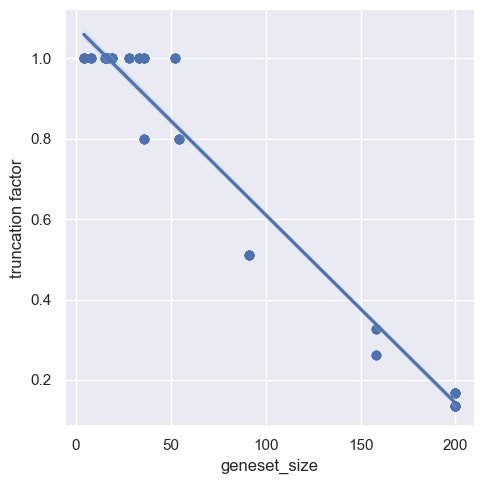

In [68]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
np.random.seed(sum(map(ord, "regression")))
sns.lmplot(x=GENESET_SIZE, y=TRUNCATION_FACTOR, data=df.query("method=='ontological_synopsis'"))
plt.show()

<Axes: xlabel='geneset_size', ylabel='truncation factor'>

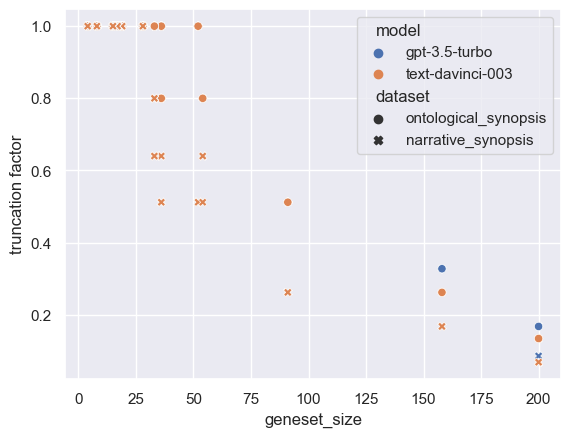

In [69]:
dftups = [(method, df.query(f"method=='{method}'")) for method in ["ontological_synopsis", "narrative_synopsis"]]
for m, mdf in dftups:
    mdf.assign(dataset=m)
concatenated = pd.concat([mdf.assign(dataset=m) for m, mdf in dftups])
sns.scatterplot(x=GENESET_SIZE, y=TRUNCATION_FACTOR, data=concatenated, style='dataset', hue='model')

In [70]:
df.query(f"{GENESET_SIZE} < 75")[[SOURCE_GENESET]].drop_duplicates()

,source geneset
0,EDS
40,FA
160,HALLMARK_HEDGEHOG_SIGNALING
280,Yamanaka-TFs
320,amigo-example
400,bicluster_RNAseqDB_1002
440,term-GO:0007212
480,endocytosis
520,go-postsynapse-calcium-transmembrane
560,go-reg-autophagy-pkra


In [71]:
means = df.query(f"{GENESET_SIZE} < 75")[eval_summary_cols].groupby(['model', 'method']).mean(numeric_only=True)
means

has top hit  in top 5  in top 10  \
model            method                                                   
N/A              random                       0.02      0.02       0.02   
                 rank_based                   0.00      0.00       0.00   
                 standard                     1.00      1.00       1.00   
                 standard_no_ontology         0.21      0.18       0.21   
gpt-3.5-turbo    narrative_synopsis           0.16      0.16       0.16   
                 no_synopsis                  0.20      0.20       0.20   
                 ontological_synopsis         0.27      0.27       0.27   
text-davinci-003 narrative_synopsis           0.11      0.07       0.11   
                 no_synopsis                  0.07      0.05       0.07   
                 ontological_synopsis         0.25      0.16       0.23   

                                       size overlap  similarity  num terms  \
model            method                                                      
N/A              random                        0.86    4.71e-03      23.36   
                 rank_based                    1.50    9.04e-03      24.36   
                 standard                    119.57    1.00e+00     119.57   
                 standard_no_ontology          8.62    6.18e-02      12.14   
gpt-3.5-turbo    narrative_synopsis            1.77    2.83e-02       5.14   
                 no_synopsis                   2.25    2.60e-02       5.45   
                 ontological_synopsis          2.18    3.44e-02       5.07   
text-davinci-003 narrative_synopsis            1.61    1.33e-02       9.54   
                 no_synopsis                   1.38    1.14e-02       7.75   
                 ontological_synopsis          2.14    2.09e-02      10.23   

                                       nr size overlap  nr similarity  
model            method                                                
N/A              random                           0.20       4.96e-03  
                 rank_based                       0.23       8.32e-03  
                 standard                        14.71       1.00e+00  
                 standard_no_ontology             1.75       4.09e-02  
gpt-3.5-turbo    narrative_synopsis               0.46       4.04e-02  
                 no_synopsis                      0.39       2.42e-02  
                 ontological_synopsis             0.62       4.73e-02  
text-davinci-003 narrative_synopsis               0.38       1.67e-02  
                 no_synopsis                      0.23       1.06e-02  
                 ontological_synopsis             0.73       3.13e-02

In [72]:
means.query("method != 'standard'").style.highlight_max(axis=0, props='font-weight:bold').format(precision=3)

## Looking at individual gene sets

In [22]:

def terms_summary(df):
    term_dict = {}
    for _, row in df.iterrows():
        model = row['model'] 
        if "turbo" in model:
            model = "turbo"
        elif "davinci" in model:
            model = "dav"
        else:
            model = ""
        method = row['method'].replace('_', ' ')
        mm = f"{model} {method}"
        if method == "standard":
            nr_term_ids = list(filter_redundant(row[TERM_IDS]))
        else:
            nr_term_ids = None
        for ix, t_id in enumerate(row[TERM_IDS]):
            if t_id not in term_dict:
                t = {"id": t_id, "label": go.label(t_id), "redundant": False}
                term_dict[t_id] = t
            else:
                t = term_dict[t_id]
            t[mm] = ix
            if nr_term_ids and t_id not in nr_term_ids:
                t["redundant"] = True
    objs = list(term_dict.values())
    return pd.DataFrame(objs)

### Peroxisome

In [23]:
peroxisome = df.query(f"{GENESET} == 'peroxisome-0'").sort_values("similarity", ascending=False)
peroxisome[eval_summary_cols]

,model,method,has top hit,in top 5,in top 10,size overlap,similarity,num terms,nr size overlap,nr similarity
746,N/A,standard,True,True,True,62,1.000000,62,10,1.000000
726,N/A,standard,True,True,True,62,1.000000,62,10,1.000000
741,gpt-3.5-turbo,ontological_synopsis,False,False,False,3,0.048387,3,0,0.000000
740,gpt-3.5-turbo,no_synopsis,False,False,False,3,0.045455,8,0,0.000000
722,gpt-3.5-turbo,narrative_synopsis,False,False,False,2,0.031250,9,1,0.076923
742,gpt-3.5-turbo,narrative_synopsis,False,False,False,2,0.031250,4,1,0.083333
721,gpt-3.5-turbo,ontological_synopsis,False,False,False,2,0.030769,5,0,0.000000
720,gpt-3.5-turbo,no_synopsis,False,False,False,1,0.015625,3,0,0.000000
723,text-davinci-003,no_synopsis,False,False,False,1,0.015385,5,0,0.000000
724,text-davinci-003,ontological_synopsis,False,False,False,1,0.014706,8,0,0.000000


In [24]:
# terms_summary(peroxisome).style.highlight_min(axis=1, props='font-weight:bold', numeric_only=True)
terms_summary(peroxisome)

,id,label,redundant,standard,turbo no synopsis,dav no synopsis,turbo ontological synopsis,turbo narrative synopsis,dav ontological synopsis,dav narrative synopsis,rank based,random
0,GO:0006625,protein targeting to peroxisome,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,GO:0072663,establishment of protein localization to perox...,True,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,GO:0072662,protein localization to peroxisome,True,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,GO:0015919,peroxisomal membrane transport,False,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,GO:0043574,peroxisomal transport,True,4.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
108,GO:0032266,phosphatidylinositol-3-phosphate binding,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
109,GO:0046967,cytosol to endoplasmic reticulum transport,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
110,GO:0051445,regulation of meiotic cell cycle,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
111,GO:0071542,dopaminergic neuron differentiation,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0


## Sensory Ataxia

In [62]:
ataxia = df.query(f"{GENESET} == 'sensory ataxia-0'").sort_values("similarity", ascending=False)
ataxia[eval_summary_cols]                                                           

,model,method,has top hit,in top 5,in top 10,size overlap,similarity,num terms,nr size overlap,nr similarity
826,N/A,standard,True,True,True,9,1.00,9,3,1.00
806,N/A,standard,True,True,True,9,1.00,9,3,1.00
822,gpt-3.5-turbo,narrative_synopsis,True,True,True,2,0.20,3,2,0.50
802,gpt-3.5-turbo,narrative_synopsis,False,False,False,2,0.20,3,2,0.50
821,gpt-3.5-turbo,ontological_synopsis,True,True,True,2,0.20,3,2,0.50
801,gpt-3.5-turbo,ontological_synopsis,True,True,True,2,0.18,4,0,0.00
800,gpt-3.5-turbo,no_synopsis,True,True,True,2,0.13,8,1,0.11
828,N/A,random,False,False,False,0,0.00,14,0,0.00
827,N/A,standard_no_ontology,False,False,False,0,0.00,0,0,0.00
825,text-davinci-003,narrative_synopsis,False,False,False,0,0.00,8,0,0.00


In [63]:
terms_summary(ataxia)

,id,label,redundant,standard,turbo narrative synopsis,turbo ontological synopsis,turbo no synopsis,dav ontological synopsis,rank based,random,dav narrative synopsis,dav no synopsis
0,GO:0042552,myelination,False,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN
1,GO:0008366,axon ensheathment,True,1.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN
2,GO:0007272,ensheathment of neurons,True,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,GO:0007422,peripheral nervous system development,False,3.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
4,GO:0014037,Schwann cell differentiation,True,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,GO:0010001,glial cell differentiation,True,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,GO:0032287,peripheral nervous system myelin maintenance,True,6.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
7,GO:0006264,mitochondrial DNA replication,False,7.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,GO:0042063,gliogenesis,True,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,GO:0031175,neuron projection development,False,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
print(retrieve_payload("sensory ataxia-0", "gpt-3.5-turbo.ontological_synopsis").response_text)

Summary: These genes are involved in various processes related to the peripheral nervous system and nucleic acid metabolism, including myelination, DNA replication, and protein ubiquitination.
Mechanism: These genes may be involved in the maintenance, repair, and regulation of the peripheral nervous system and nucleic acids.
Enriched Terms: peripheral nervous system myelin maintenance; myelination; DNA replication; protein ubiquitination.


In [65]:
print(retrieve_payload("sensory ataxia-0", "gpt-3.5-turbo.narrative_synopsis").response_text)

Summary: Genes are involved in various neurological and metabolic disorders. Enriched terms include "peripheral nervous system development," "neurological system process," and "mitochondrial DNA replication."

Mechanism: The enriched terms suggest a common theme of neurological and metabolic dysfunction related to the peripheral nervous system and mitochondrial function.

Enriched Terms: peripheral nervous system development; neurological system process; mitochondrial DNA replication.


In [66]:
print(retrieve_payload("sensory ataxia-0", "gpt-3.5-turbo.no_synopsis").response_text)

Summary: Enriched terms are related to myelin sheath formation, neuronal development, and protein processing.
Enriched Terms: Myelination; Neuron development; Protein folding; Protein targeting to ER; ATP binding; Axon ensheathment; Mitochondrial genome maintenance; Zinc ion binding.


## Endocytosis

In [36]:
def retrieve_payload(geneset, method):
    for comp in comps:
        if comp.name == geneset:
            return comp.payloads[method]

In [42]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)


In [43]:
endocytosis = df.query(f"{GENESET} == 'endocytosis-0'").sort_values("similarity", ascending=False)
terms_summary(endocytosis)

,id,label,redundant,standard,standard no ontology,turbo no synopsis,turbo ontological synopsis,dav narrative synopsis,turbo narrative synopsis,dav ontological synopsis,dav no synopsis,random,rank based
0,GO:0006907,pinocytosis,False,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,GO:0006897,endocytosis,True,1.0,6.0,0.0,0.0,4.0,0.0,4.0,NaN,NaN,NaN
2,GO:0044351,macropinocytosis,True,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,GO:0016192,vesicle-mediated transport,True,3.0,NaN,NaN,2.0,NaN,NaN,NaN,2.0,NaN,NaN
4,GO:0030100,regulation of endocytosis,False,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,GO:0006810,transport,True,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,GO:0051234,establishment of localization,True,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,GO:0045807,positive regulation of endocytosis,True,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,GO:0060627,regulation of vesicle-mediated transport,True,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,GO:0051179,localization,True,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
print(retrieve_payload("endocytosis-0", "gpt-3.5-turbo.narrative_synopsis").prompt)


I will give you a list of genes together with descriptions of their functions.
Perform a term enrichment test on these genes.
i.e. tell me what the commonalities are in their function.
Make use of classification hierarchies when you do this.
Only report gene functions in common, not diseases.
e.g if gene1 is involved in "toe bone growth" and gene2 is involved in "finger morphogenesis"
then the term "digit development" would be enriched as represented by gene1 and gene2.
Only include terms that are statistically over-represented.
Also include a hypothesis of the underlying biological mechanism or pathway.

Provide results in the format

Summary: <high level summary>
Mechanism: <mechanism>
Enriched Terms: <term1>; <term2>; <term3>

###

Here are the gene summaries:
MAPKAPK2: This gene encodes a member of the Ser/Thr protein kinase family. This kinase is regulated through direct phosphorylation by p38 MAP kinase. In conjunction with p38 MAP kinase, this kinase is known to be involved in 

In [39]:
print(retrieve_payload("endocytosis-0", "gpt-3.5-turbo.narrative_synopsis").response_text)

Summary: Cytoskeletal reorganization, intracellular trafficking, endocytosis, and signaling pathways.
Mechanism: The enriched terms involve cellular processes related to protein trafficking, endocytosis, and signaling pathways, which are essential for cell homeostasis.
Enriched Terms: Endocytosis; Signaling pathway; Protein trafficking.

Note: These terms were statistically over-represented among the listed genes. The cytoskeletal reorganization was not statistically significant enough to be included. The underlying biological mechanism is likely related to the regulation of intracellular trafficking and signaling pathways, which are important for the maintenance of cellular homeostasis.


In [40]:
print(retrieve_payload("endocytosis-0", "gpt-3.5-turbo.ontological_synopsis").prompt)


I will give you a list of genes together with descriptions of their functions.
Perform a term enrichment test on these genes.
i.e. tell me what the commonalities are in their function.
Make use of classification hierarchies when you do this.
Only report gene functions in common, not diseases.
e.g if gene1 is involved in "toe bone growth" and gene2 is involved in "finger morphogenesis"
then the term "digit development" would be enriched as represented by gene1 and gene2.
Only include terms that are statistically over-represented.
Also include a hypothesis of the underlying biological mechanism or pathway.

Provide results in the format

Summary: <high level summary>
Mechanism: <mechanism>
Enriched Terms: <term1>; <term2>; <term3>

###

Here are the gene summaries:
MAPKAPK2: Enables protein serine/threonine kinase activity. Involved in several processes, including peptidyl-serine phosphorylation; regulation of gene expression; and vascular endothelial growth factor receptor signaling pa

### Generalization Test

In [28]:
hydrolase = df.query(f"{GENESET} == 'hydrolase activity, hydrolyzing O-glycosyl compounds-0'").sort_values("similarity", ascending=False)
hydrolase[eval_summary_cols]                                                           

,model,method,has top hit,in top 5,in top 10,size overlap,similarity,num terms,nr size overlap,nr similarity
606,N/A,standard,True,True,True,208,1.000000,208,21,1.000000
626,N/A,standard,True,True,True,208,1.000000,208,21,1.000000
627,N/A,standard_no_ontology,True,False,False,88,0.411215,94,11,0.207547
607,N/A,standard_no_ontology,True,False,False,88,0.411215,94,11,0.207547
604,text-davinci-003,ontological_synopsis,False,False,False,8,0.035398,26,1,0.027027
621,gpt-3.5-turbo,ontological_synopsis,False,False,False,7,0.033333,9,0,0.000000
600,gpt-3.5-turbo,no_synopsis,False,False,False,6,0.028302,10,1,0.038462
601,gpt-3.5-turbo,ontological_synopsis,False,False,False,4,0.019139,5,0,0.000000
602,gpt-3.5-turbo,narrative_synopsis,False,False,False,4,0.019139,5,0,0.000000
603,text-davinci-003,no_synopsis,False,False,False,4,0.019048,6,1,0.038462


In [29]:
terms_summary(hydrolase)

,id,label,redundant,standard,standard no ontology,turbo narrative synopsis,dav ontological synopsis,turbo no synopsis,dav no synopsis,turbo ontological synopsis,rank based,random,dav narrative synopsis
0,GO:0004553,"hydrolase activity, hydrolyzing O-glycosyl com...",False,0.0,62.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,GO:0016798,"hydrolase activity, acting on glycosyl bonds",True,1.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,GO:0005975,carbohydrate metabolic process,False,2.0,0.0,NaN,1.0,0.0,3.0,NaN,NaN,NaN,NaN
3,GO:0016787,hydrolase activity,True,3.0,NaN,NaN,19.0,3.0,NaN,NaN,NaN,NaN,NaN
4,GO:1901136,carbohydrate derivative catabolic process,False,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
481,MESH:D006017,None,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
482,hyaluronidases,None,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
483,lysozyme,None,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
484,chitinase,None,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0


## Summaries

In [30]:
objs = []
for c in comps:
    for m, payload in c.payloads.items():
        if payload.summary:
            objs.append({"model": c.model, "geneset": c.name, "method": m, "summary": payload.summary})

In [31]:
sdf = pd.DataFrame(objs)

In [41]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
sdf

,model,geneset,method,summary
0,None,EDS-0,gpt-3.5-turbo.no_synopsis,Summary: Genes involved in extracellular matrix formation and collagen processing.\n
1,None,EDS-0,gpt-3.5-turbo.ontological_synopsis,Summary: Genes are enriched for extracellular matrix organization and collagen fibril organization.\nMechanism: The underlying mechanism is likely related to the formation and regulation of collagen and the extracellular matrix.\n
2,None,EDS-0,gpt-3.5-turbo.narrative_synopsis,"Summary: Genes associated with connective tissue disorders and extracellular matrix synthesis and organization are enriched for terms related to collagen and proteoglycan biosynthesis and modification.\nMechanism: The genes identified in this analysis are involved in extracellular matrix synthesis and organization, particularly in the biosynthesis and modification of collagen and proteoglycans. Disruption of these processes can lead to connective tissue disorders such as Ehlers-Danlos syndrome.\n"
3,None,EDS-0,text-davinci-003.no_synopsis,COULD NOT PARSE
4,None,EDS-0,text-davinci-003.ontological_synopsis,"Summary: Genes in this list are involved in extracellular matrix organization, collagen fibril organization, endodermal cell differentiation, zymogen activation, cellular zinc homeostasis and skin morphogenesis\nMechanism: These genes work together to promote tissue development, structural integrity and proper organization of the extracellular matrix, as well as communication and balance of the cellular microenvironment.\n"
5,None,EDS-0,text-davinci-003.narrative_synopsis,"Summary: The genes listed encode for proteins involved in collagen biosynthesis, cell differentiation, transcription factors and zinc transporters, which all play a role in connective tissue formation and stability.\nMechanism: The proteins encoded by these genes are involved in the biosynthesis and stability of collagens and other extracellular matrix components. They are thus involved in the formation of strong and flexible connective tissue fibres, and when mutations occur, can lead to an increased susceptibility to Ehlers-Danlos Syndrome and other connective tissue disorders.\n"
6,None,EDS-1,gpt-3.5-turbo.no_synopsis,"Summary: The list of genes provided is enriched for extracellular matrix and collagen-related functions, as well as processes related to glycosaminoglycan metabolism and immune response.\n\n"
7,None,EDS-1,gpt-3.5-turbo.ontological_synopsis,"Summary: The genes are generally involved in extracellular matrix organization and collagen fibril assembly, and many are implicated in various forms of Ehlers-Danlos syndrome.\nMechanism: The underlying mechanism is likely related to collagen synthesis and extracellular matrix architecture.\n"
8,None,EDS-1,gpt-3.5-turbo.narrative_synopsis,"Summary: Connective tissue disorders, particularly Ehlers-Danlos syndrome, are enriched among these genes. \n\nMechanism: The enriched terms suggest a common biological mechanism of defective collagen formation and organization, possibly due to mutations in genes involved in collagen biosynthesis, folding, and post-translational modification.\n\n"
9,None,EDS-1,text-davinci-003.no_synopsis,"The genes provided contain multiple proteins involved in the regulation of collagen and glycosaminoglycan expression, as well as proteins related to the formation of cell surface receptors for extracellular ligands. Furthermore, the list contains genes related to transcriptional regulation, cell morphology, and the enhancement of enzyme activity. Overall, these genes are enriched in functions related to collagen and glycosaminoglycan metabolism, cell surface receptor formation, transcriptional regulation, cell morphology, and enzyme activity. \n"


In [ ]:
sdf.query("geneset == 'sensory ataxia-0'")